In [2]:
cd ..

/home/hyunjun/workspace/FactorSearch (mom)


In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
algo = 'RL'

seed = 3
pf = pd.read_csv(f'result/seed{seed}/PF_{algo}.csv', index_col=0)
pv = pd.read_csv(f'result/seed{seed}/PV_{algo}.csv', index_col=0)
po = pd.read_csv(f'result/seed{seed}/PO_{algo}.csv', index_col=0)
ti = pd.read_csv(f'result/seed{seed}/TI_{algo}.csv', index_col=0, dtype=str)
me = pd.read_csv(f'result/seed{seed}/Me_{algo}.csv', index_col=0)
we = pd.read_csv(f'result/seed{seed}/We_{algo}.csv', index_col=0)

np.set_printoptions(suppress=True)
we.values

In [171]:
kospi_ = pd.read_csv('data1/kospi.csv', index_col=0)['2015':'2024']
dates = kospi_.index
kospi = kospi_.values

pv_path = lambda algo, seed: f'result/seed{seed}/PV_{algo}.csv'
me_path = lambda algo, seed: f'result/seed{seed}/Me_{algo}.csv'

pv_random = [pd.read_csv(pv_path('random', seed), index_col=0).values.reshape(-1,1) for seed in range(1, 6)]
re_random = [pd.read_csv(me_path('random', seed), index_col=0).values.reshape(-1,1) for seed in range(1, 6)]
pv_rl = [pd.read_csv(pv_path('RL', seed), index_col=0) for seed in range(1, 6)]
re_rl = [pd.read_csv(me_path('RL', seed), index_col=0) for seed in range(1, 6)]

pv_mean_ran = np.mean(np.concatenate(pv_random, axis=-1), axis=-1)
pv_std_ran = np.std(np.concatenate(pv_random, axis=-1), axis=-1)
pv_mean_rl = np.mean(np.concatenate(pv_rl, axis=-1), axis=-1)
pv_std_rl = np.std(np.concatenate(pv_rl, axis=-1), axis=-1)

In [172]:
def get_alpha(pv):
    free = 0.04 / 12
    pv = np.array(pv).reshape(-1)
    R_i = (pv[1:] / pv[:-1]) - 1
    R_f = (kospi[1:] / kospi[:-1]) - 1
    alpha = np.polyfit(R_i-free, R_f-free, 1)[-1]
    return alpha

In [173]:
sharpe_random = np.concatenate(re_random, axis=-1)[0] 
rankic_random = np.concatenate(re_random, axis=-1)[1] 
mdd_random = np.concatenate(re_random, axis=-1)[2] 
alpha_random = np.concatenate(list(map(get_alpha, pv_random)), -1)

sharpe_rl = np.concatenate(re_rl, axis=-1)[0] 
rankic_rl = np.concatenate(re_rl, axis=-1)[1] 
mdd_rl = np.concatenate(re_rl, axis=-1)[2] 
alpha_rl = np.concatenate(list(map(get_alpha, pv_rl)), -1)


print(f'Random search Sharpe: {sharpe_random} \n')
print(f'Random search RankIC: {rankic_random} \n')
print(f'Random search MDD: {mdd_random} \n')
print(f'Random search Alpha: {alpha_random} \n')

print(f'RL search Sharpe: {sharpe_rl} \n')
print(f'RL search RankIC: {rankic_rl} \n')
print(f'RL search MDD: {mdd_rl} \n')
print(f'RL search Alpha: {alpha_rl} \n')

Random search Sharpe: [0.1022 0.0865 0.1225 0.0279 0.0263] 

Random search RankIC: [0.2846 0.2866 0.3272 0.286  0.2619] 

Random search MDD: [37.481  48.0129 39.1664 35.7009 40.7018] 

Random search Alpha: [0.00033914 0.00068293 0.00074823 0.0005369  0.00053122] 

RL search Sharpe: [0.0279 0.1225 0.0433 0.0433 0.0419] 

RL search RankIC: [0.286  0.3272 0.2963 0.2963 0.2917] 

RL search MDD: [35.7009 39.1664 43.565  43.565  42.4181] 

RL search Alpha: [0.0005369  0.00074823 0.00063903 0.00063903 0.00059325] 



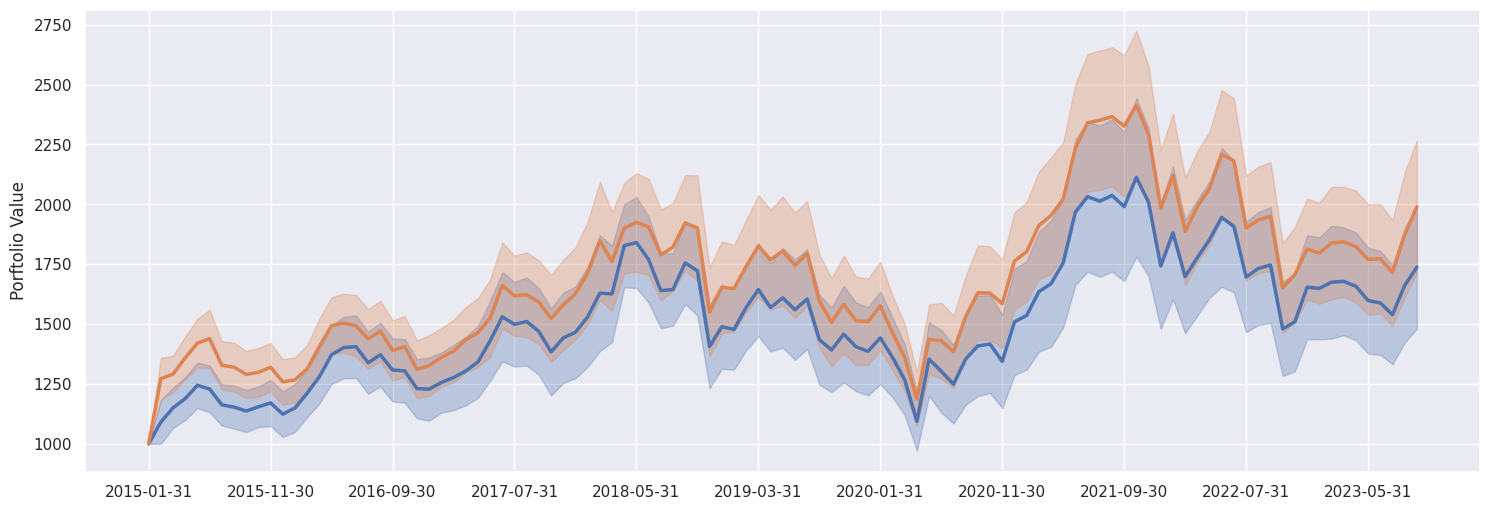

In [175]:
linewidth = 2.5

sns.set(style='darkgrid')
plt.figure(figsize=(18, 6))
plt.xticks([10*i for i in range(11)], dates[[10*i for i in range(11)]])
plt.ylabel('Porftolio Value')
plt.plot(pv_mean_rl, color="C0", linewidth=linewidth)
plt.plot(pv_mean_ran, color="C1", linewidth=linewidth)

plt.fill_between(x=np.arange(pv_mean_rl.shape[0]), y1=pv_mean_rl + 0.5*pv_std_rl, y2=pv_mean_rl - 0.5*pv_std_rl, alpha=0.3, color="C0")
plt.fill_between(x=np.arange(pv_mean_ran.shape[0]), y1=pv_mean_ran + 0.5*pv_std_ran, y2=pv_mean_ran - 0.5*pv_std_ran, alpha=0.3, color="C1")

In [ ]:
from agent import RANDOMSEARCH

all = ['1M', '3M', '6M', '9M', '12M', 
       '12_1M', '12_3M', '12_6M', 
       '12_9M', 'Kratio']

M1 = []
M3 = []
M6 = []
M9 = []
M12 = []
M12_1 = []
M12_3 = []
M12_6 = []
M12_9 = []
KRATIO = []

config = {'Number': 10, 
          'Quantile': 1,
          'Balance': 1000,
          'Quarter': '1Q',
          'Factors': all,
          'Dim': 10}

for factor in all:
    
    print(factor)
    for i in range(1, 6):
        config['Quantile'] = i
        config['Factors'] = [factor]

        randomsearch = RANDOMSEARCH(config)
        randomsearch.init()
        PVs, PFs, TIs, POs, result = randomsearch.test('2001','2016')
        print(result['sharpe'])

        if factor == '1M':
            M1.append(PVs)

        if factor == '3M':
            M3.append(PVs)

        if factor == '6M':
            M6.append(PVs)

        if factor == '9M':
            M9.append(PVs)

        if factor == '12M':
            M12.append(PVs)

        if factor == '12_1M':
            M12_1.append(PVs)

        if factor == '12_3M':
            M12_3.append(PVs)

        if factor == '12_6M':
            M12_6.append(PVs)

        if factor == '12_9M':
            M12_9.append(PVs)

        if factor == 'Kratio':
            KRATIO.append(PVs)

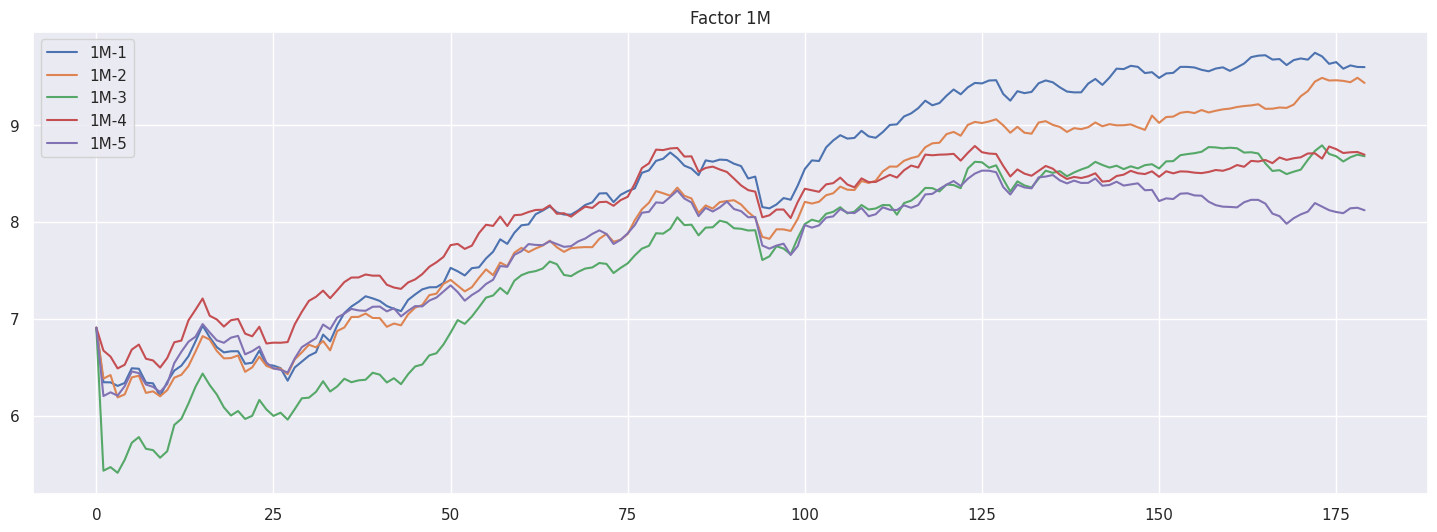

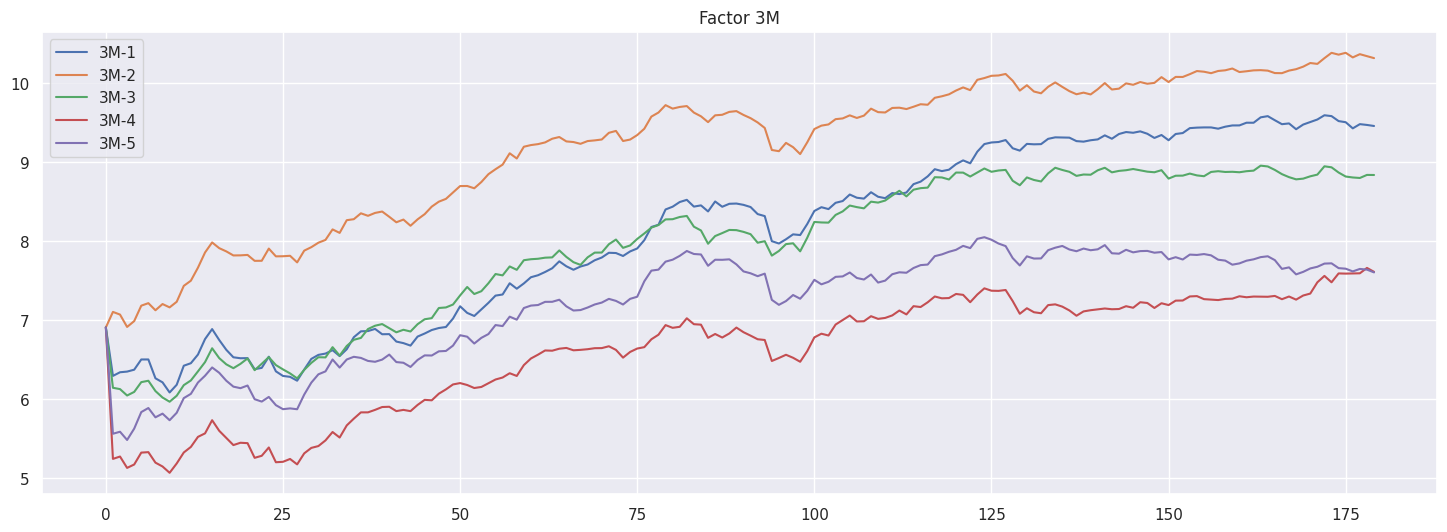

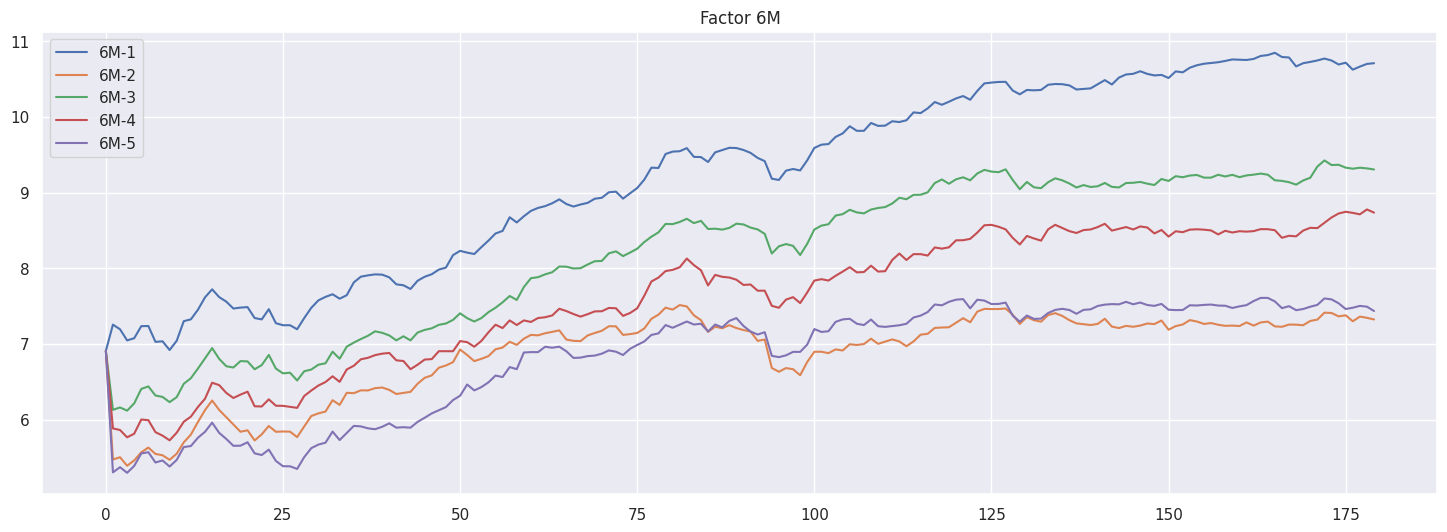

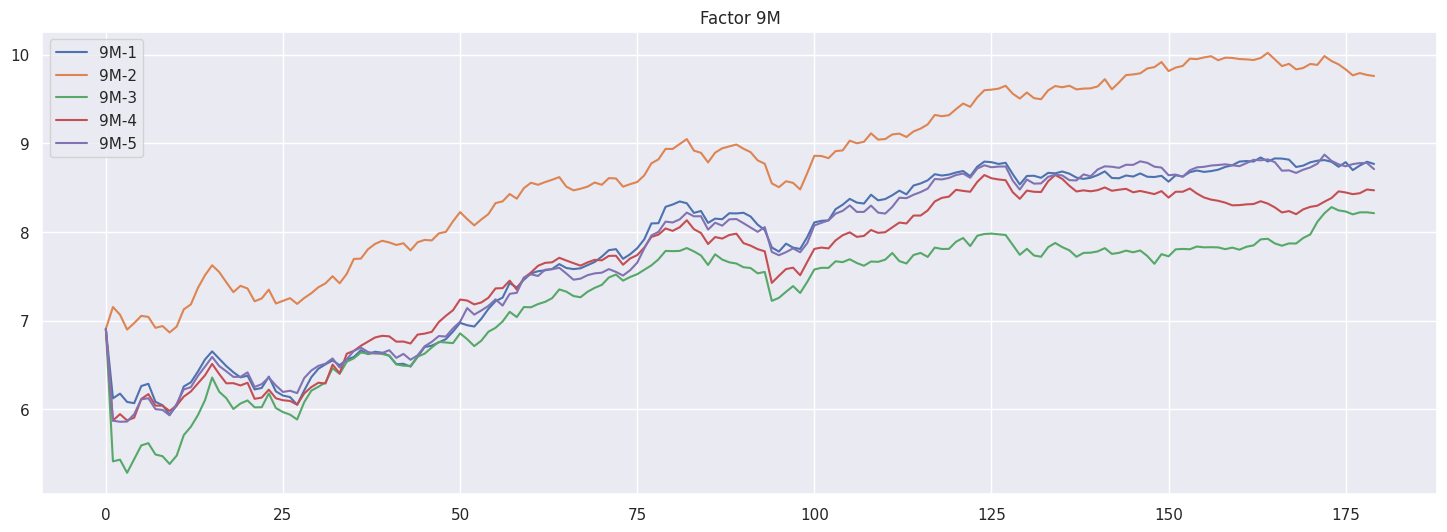

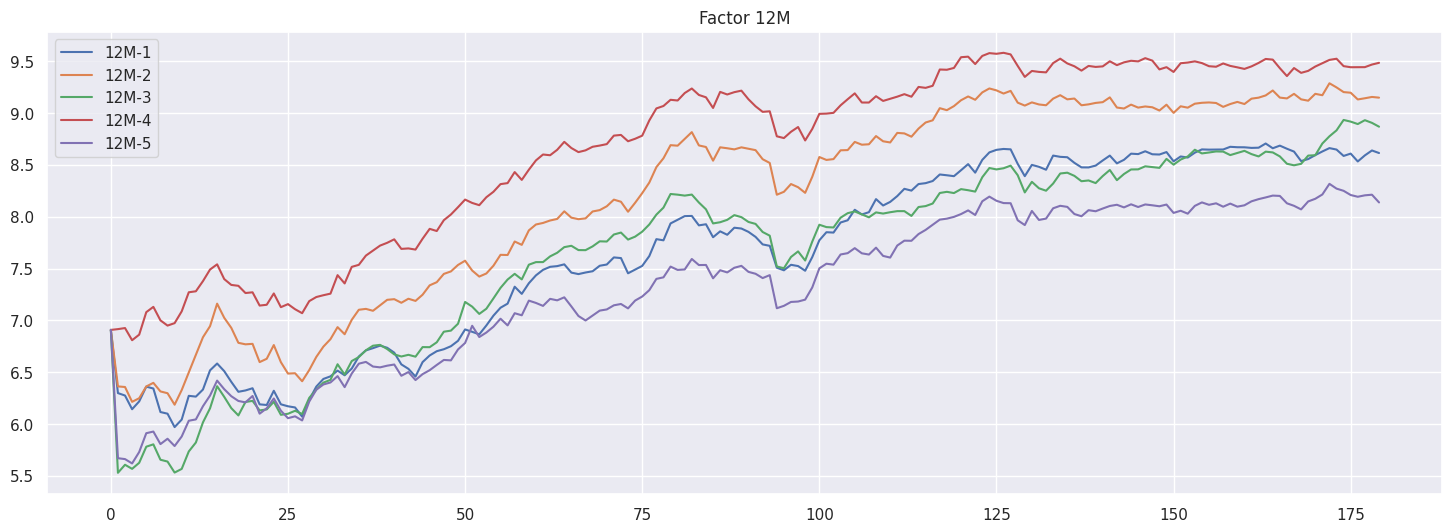

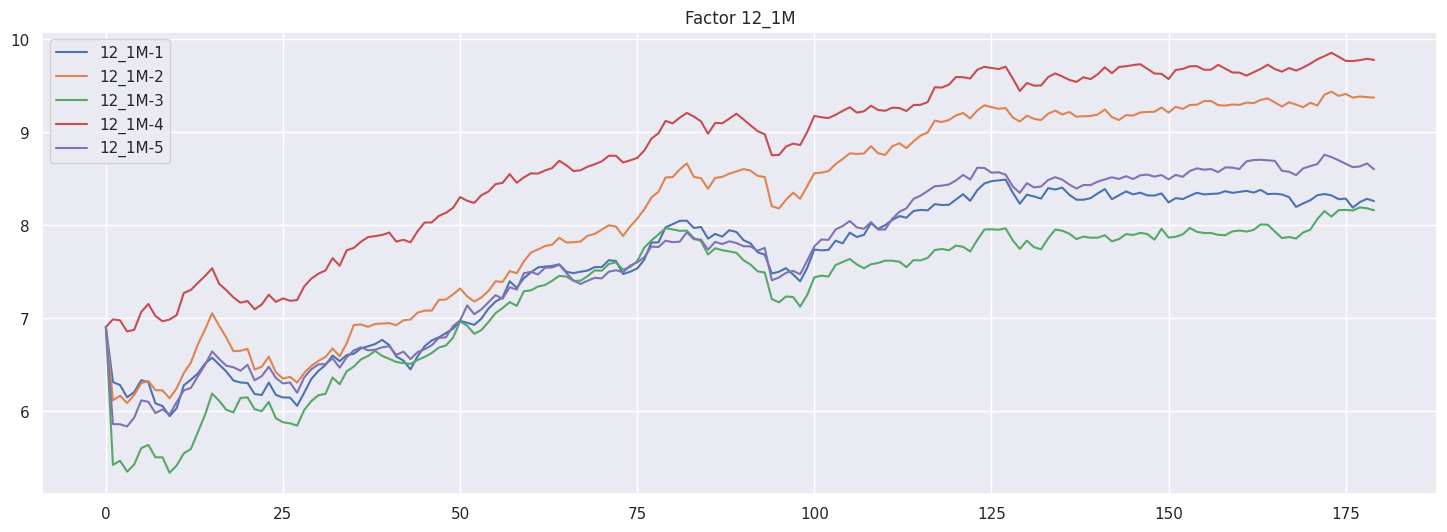

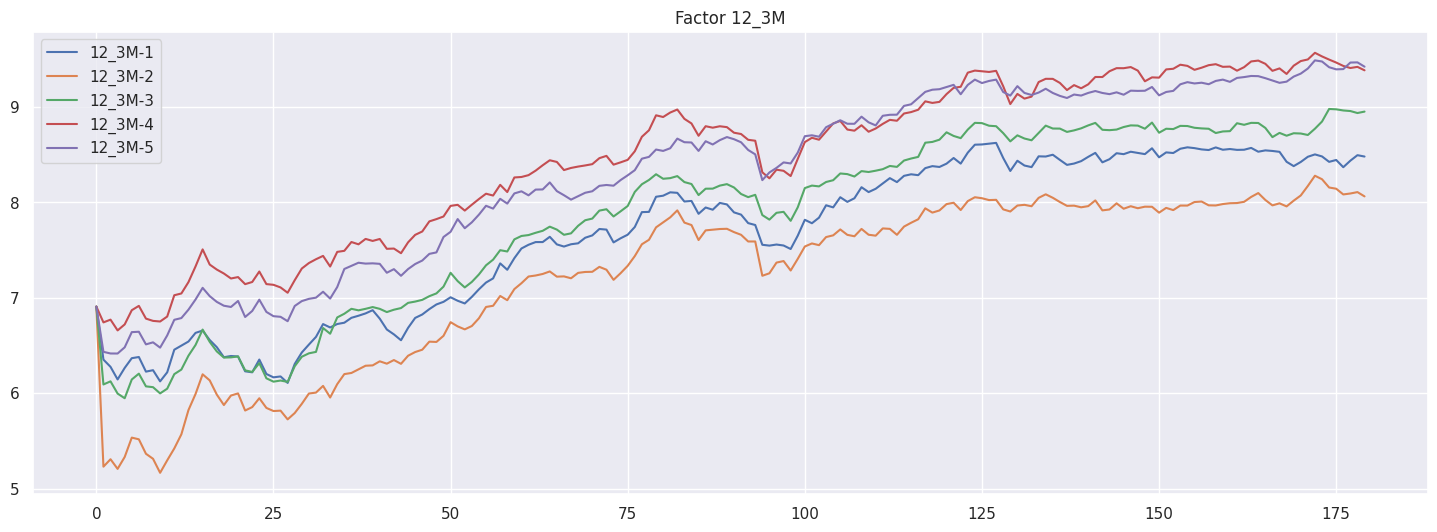

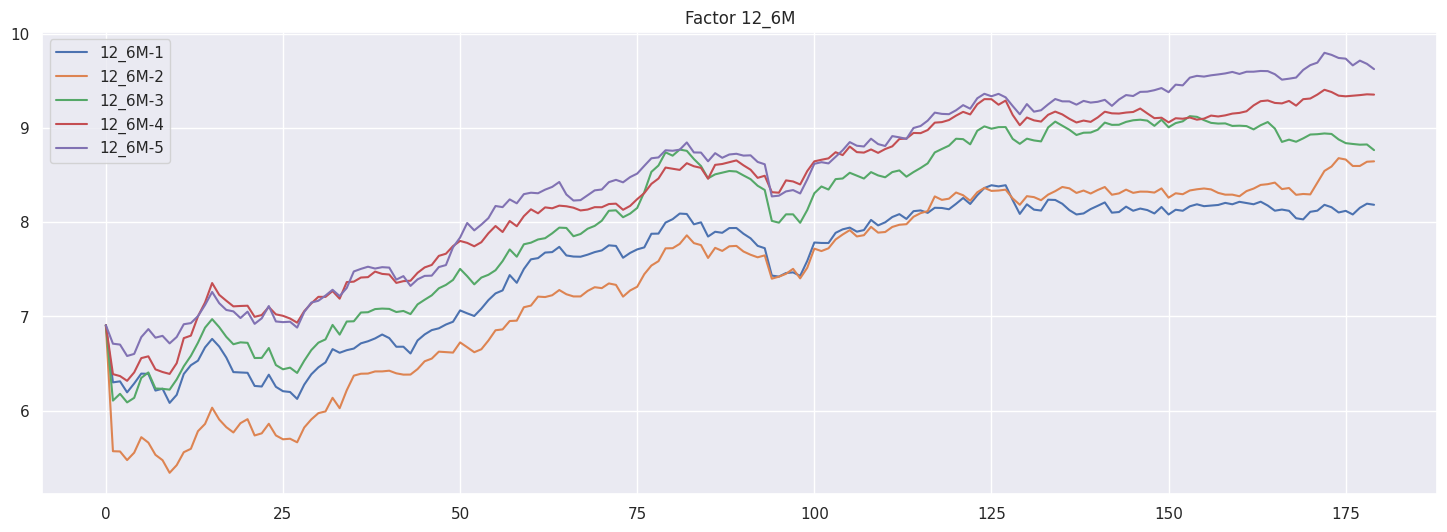

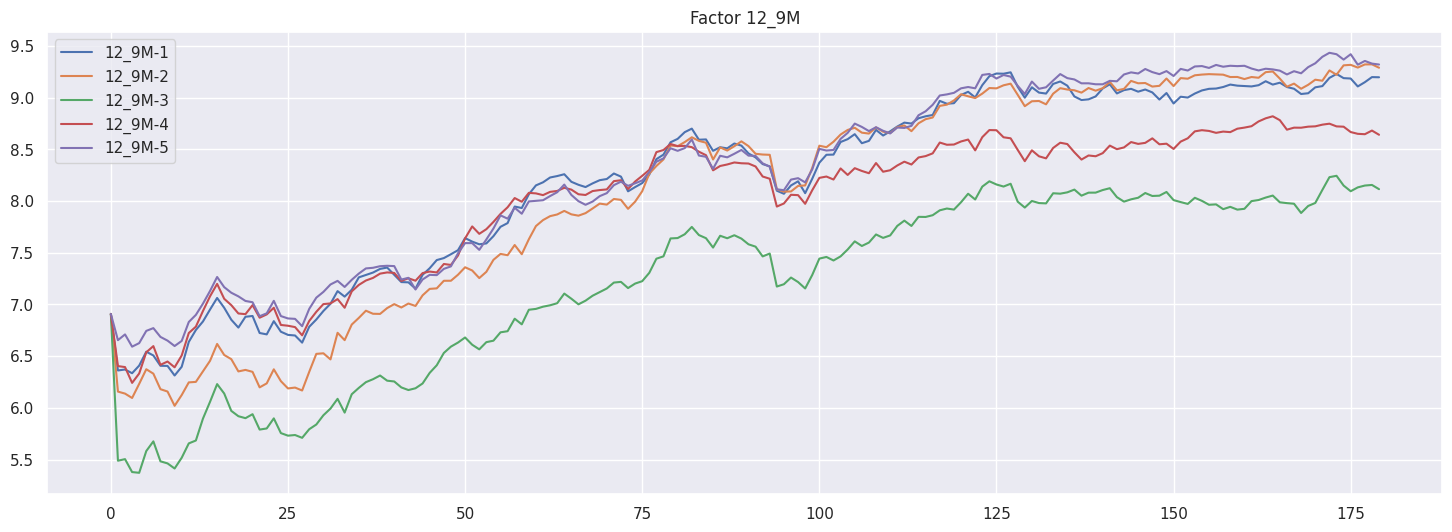

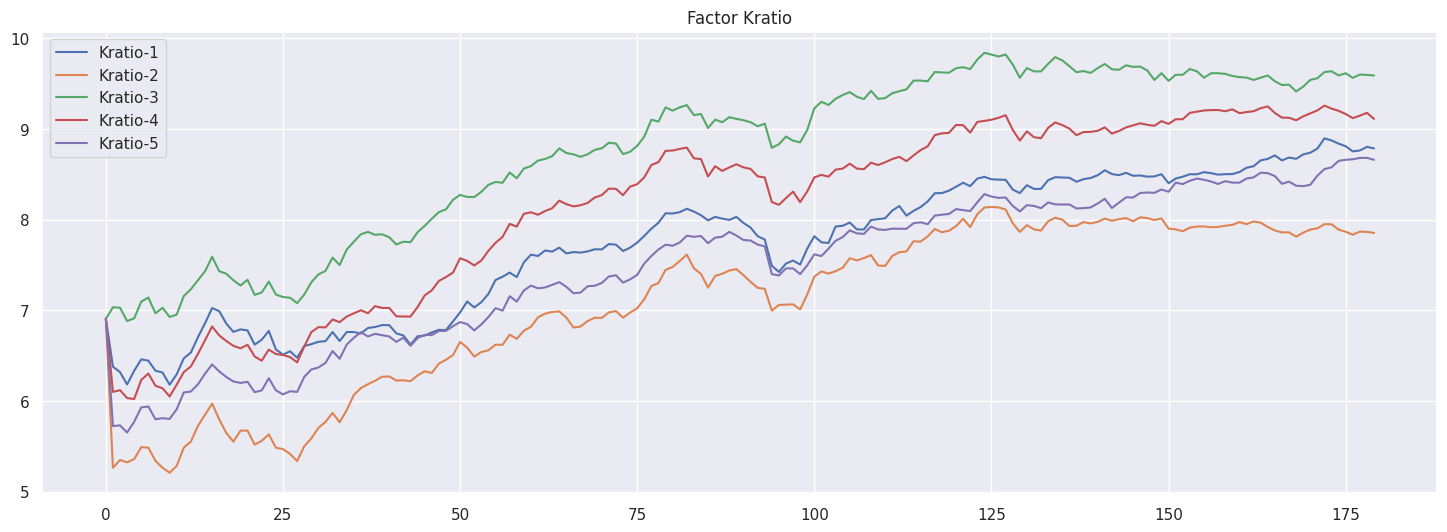

In [7]:
dicts = {'1M':M1, '3M':M3, '6M':M6, '9M':M9, 
         '12M':M12, '12_1M':M12_1, '12_3M':M12_3, 
         '12_6M':M12_6, '12_9M':M12_9, 'Kratio':KRATIO}


for factor in all:
    sns.set(style='darkgrid')
    plt.figure(figsize=(18, 6))

    for i in [0, 1, 2, 3, 4]:
        plt.plot(np.log(dicts[factor][i]), label=f'{factor}-{i+1}')
        plt.legend()
        plt.title(f'Factor {factor}')

    plt.show()